In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

from datetime import datetime as dt

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Custom Files

In [3]:
from data_io import DataIO # Custom IO file

# Input/Output of RGA and Temperature Data

In [4]:
Path = "/home/ael59/project/run_data/2020_11_09/" # data file path

In [5]:
IO = DataIO(Path)

In [6]:
IO.Unzip()

In [7]:
RGA_Data = IO.GetRGAData()

In [8]:
Temp = IO.GetTemperatureData()

In [9]:
#data.to_hdf(p+"10_19_rga_2020.h5", key='data')

In [10]:
RGA_Data.sort_values(by=['Datetime', 'Mass'], inplace=True)
#RGA_Data

In [11]:
Temp.sort_values(by='Datetime', inplace=True)
#Temp

### Times

In [12]:
# Starting RGA Time
rga_start = RGA_Data['Datetime'].sort_values().unique()[0]
#rga_start

In [13]:
# Starting temperature time
temps_start = Temp['Datetime'].sort_values().unique()[0]
#temps_start

In [14]:
# Find the EARLIEST time to calculate timedeltas from.
if rga_start < temps_start:
    start_datetime = rga_start
else:
    start_datetime = temps_start

In [15]:
#start_datetime

In [16]:
temp_times = (Temp['Datetime'] - start_datetime)/np.timedelta64(1, 's')
#temp_times

In [17]:
# Separate by mass
H2_data = RGA_Data[RGA_Data['Mass'] == 2.0]
H2O_data = RGA_Data[RGA_Data['Mass'] == 18.0]
N2_data = RGA_Data[RGA_Data['Mass'] == 28.0]
O2_data = RGA_Data[RGA_Data['Mass'] == 32.0]
CO2_data = RGA_Data[RGA_Data['Mass'] == 44.0]

In [18]:
rga_times = (RGA_Data['Datetime'].unique() - start_datetime)/np.timedelta64(1, 's')
H2_times = (H2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
H2O_times = (H2O_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
N2_times = (N2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
O2_times = (O2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
CO2_times = (CO2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')

In [19]:
#CO2_times

### Temperature Interpolation

In [20]:
#pd.to_numeric(Temp['CH1'])

In [21]:
CO2_ch1_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH1']))
CO2_ch2_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH2']))

### Final Data Frames

In [22]:
## Build CO2 final data frame
CO2_final_data = pd.DataFrame(data=CO2_times)
CO2_final_data.columns = ['Exp_Time']
# Torr now
CO2_final_data['CO2_Pressure'] = CO2_data['Pressure']
# Celsius to Kelvin
CO2_final_data['ch1_lerp'] = CO2_ch1_lerp + 273.2
CO2_final_data['ch2_lerp'] = CO2_ch2_lerp + 273.2
CO2_final_data['temp_est'] = (CO2_final_data['ch1_lerp'] + CO2_final_data['ch2_lerp'])/2.0
#CO2_final_data

In [23]:
CO2_final_data.sort_values(by='Exp_Time', inplace=True)
#CO2_final_data

### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [24]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [25]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [26]:
jump1_bounds = [51000, 64600]
jump2_bounds = [64400, 89500]
jump3_bounds = [90000, 110200]
jump4_bounds = [110200, 150000]
CO2_params = [7, 5900, 800]

In [27]:
def jump_analysis(bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = CO2_final_data[CO2_final_data['Exp_Time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['Exp_Time'].unique()[0]
    jump_table['Jump_Time'] = jump_table['Exp_Time'] - jump_time_start
    time_temp_vals = jump_table[['Jump_Time', 'temp_est']].T.to_numpy()
    fit_jump = jump_table['CO2_Pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['Exp_Time'], jump_table['CO2_Pressure'], jump_fits, popt, pcov, time_temp_vals

In [28]:
def alt_jump_analysis(bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = CO2_final_data[CO2_final_data['Exp_Time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['Exp_Time'].unique()[0]
    jump_table['Jump_Time'] = jump_table['Exp_Time'] - jump_time_start
    time_temp_vals = jump_table[['Jump_Time', 'ch1_lerp']].T.to_numpy()
    fit_jump = jump_table['CO2_Pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['Exp_Time'], jump_table['CO2_Pressure'], jump_fits, popt, pcov, time_temp_vals

In [29]:
CO2_jump1_out = jump_analysis(jump1_bounds, CO2_params)
CO2_jump2_out = jump_analysis(jump2_bounds, CO2_params)
CO2_jump3_out = jump_analysis(jump3_bounds, CO2_params)
CO2_jump4_out = jump_analysis(jump4_bounds, CO2_params)

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [30]:
CO2_jump1_alt = alt_jump_analysis(jump1_bounds, CO2_params)
CO2_jump2_alt = alt_jump_analysis(jump2_bounds, CO2_params)
CO2_jump3_alt = alt_jump_analysis(jump3_bounds, CO2_params)
CO2_jump4_alt = alt_jump_analysis(jump4_bounds, CO2_params)

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [31]:
CO2_jump4_out[3]

array([2.80866994e-01, 4.80893383e+03, 3.25754357e+01])

In [32]:
CO2_jump1_alt[3]

array([6.86386181e-05, 1.89812147e+03, 5.34528993e-03])

In [33]:
#CO2_Ea_guesses = np.array([5750, 5800, 5820, 5821, 5822, 5823, 5824, 5825, 5850, 5875, 5900])
#CO2_jump4_guessfits = [pressure_fit(CO2_jump4_out[5], CO2_jump4_out[3][0], guess, CO2_jump4_out[3][2]) for guess in CO2_Ea_guesses]

In [34]:
CO2_jump4_alt[4]

array([[2.74277021e-07, 1.21708297e-02, 3.25787336e-05],
       [1.21708297e-02, 5.40100913e+02, 1.44552007e+00],
       [3.25787336e-05, 1.44552007e+00, 3.87101476e-03]])

### Plotting

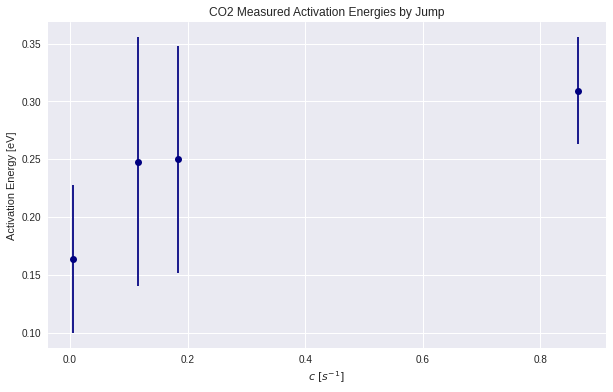

In [35]:
CO2_Ea_vals = np.array([CO2_jump1_alt[3][1], CO2_jump2_alt[3][1], CO2_jump3_alt[3][1], CO2_jump4_alt[3][1]])
CO2_Ea_errs = np.array([CO2_jump1_alt[4][1][1], CO2_jump2_alt[4][1][1], CO2_jump3_alt[4][1][1], CO2_jump4_alt[4][1][1]])
CO2_D_vals = np.array([CO2_jump1_alt[3][2], CO2_jump2_alt[3][2], CO2_jump3_alt[3][2], CO2_jump4_alt[3][2]])
CO2_D_errs = np.array([CO2_jump1_alt[4][2][2], CO2_jump2_alt[4][2][2], CO2_jump3_alt[4][2][2], CO2_jump4_alt[4][2][2]])

k_B = 8.617e-5 # Boltzmann constant in eV/K

fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(CO2_D_vals, CO2_Ea_vals*k_B, yerr=CO2_Ea_errs*k_B, xerr=CO2_D_errs, fmt='o', color='navy')

ax.set_title('CO2 Measured Activation Energies by Jump')
ax.set_xlabel('$c$ $\\left[s^{-1}\\right]$')
ax.set_ylabel('Activation Energy [eV]')

fig.savefig('images/co2_Ea_vals_2020_11_09.png', dpi=144)
plt.show()

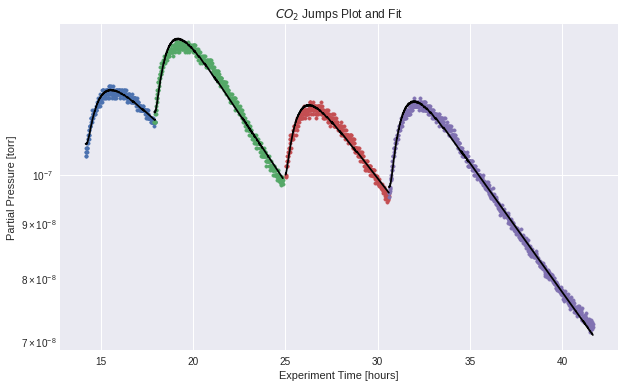

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump1_alt[0]/3600, CO2_jump1_alt[1], marker='.')
ax.plot(CO2_jump1_alt[0]/3600, CO2_jump1_alt[2], color='black')
ax.scatter(CO2_jump2_alt[0]/3600, CO2_jump2_alt[1], marker='.')
ax.plot(CO2_jump2_alt[0]/3600, CO2_jump2_alt[2], color='black')
ax.scatter(CO2_jump3_alt[0]/3600, CO2_jump3_alt[1], marker='.')
ax.plot(CO2_jump3_alt[0]/3600, CO2_jump3_alt[2], color='black')
ax.scatter(CO2_jump4_alt[0]/3600, CO2_jump4_alt[1], marker='.')
ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_alt[2], color='black')
#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$CO_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/co2_all_fits_2020_11_09.png', dpi=144)

plt.show()

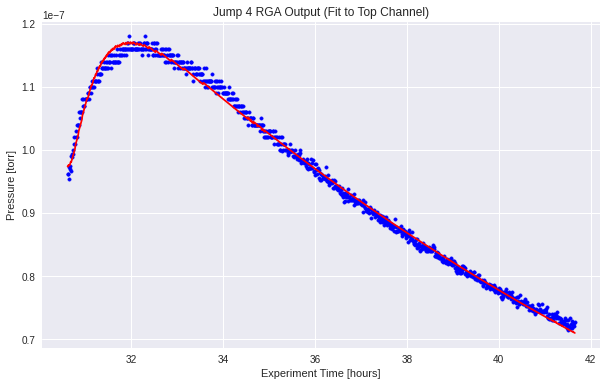

In [37]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(CO2_jump4_alt[0]/3600, CO2_jump4_alt[1], marker='.', color='blue', label='RGA Output')
ax1.plot(CO2_jump4_alt[0]/3600, CO2_jump4_alt[2], color='red', label='RGA Fit')

ax1.set_title('Jump 4 RGA Output (Fit to Top Channel)')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
#ax1.set_yscale('log')

plt.savefig('images/co2_4_alt_2020_11_09.png', dpi=144)

plt.show()

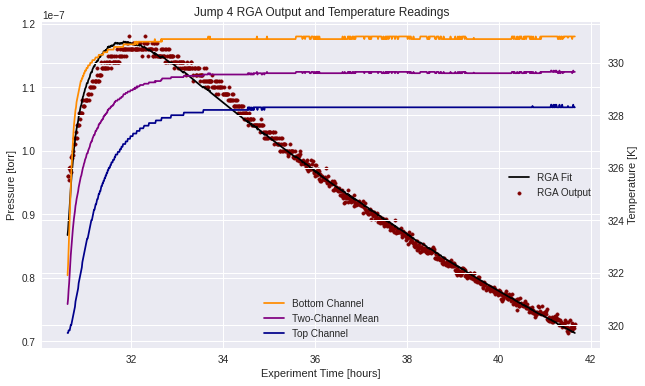

In [38]:
jump4_temps = CO2_final_data[CO2_final_data['Exp_Time'].between(jump4_bounds[0], jump4_bounds[1])][['ch1_lerp', 'ch2_lerp', 'temp_est']]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(CO2_jump4_out[0]/3600, CO2_jump4_out[1], marker='.', color='maroon', label='RGA Output')
ax1.plot(CO2_jump4_out[0]/3600, CO2_jump4_out[2], color='black', label='RGA Fit')

ax2 = ax1.twinx()

ax2.plot(CO2_jump4_out[0]/3600, jump4_temps['ch2_lerp'], color='darkorange', label='Bottom Channel')
ax2.plot(CO2_jump4_out[0]/3600, jump4_temps['temp_est'], color='purple', label='Two-Channel Mean')
ax2.plot(CO2_jump4_out[0]/3600, jump4_temps['ch1_lerp'], color='darkblue', label='Top Channel')

ax1.set_title('Jump 4 RGA Output and Temperature Readings')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
ax1.legend(loc='right')

ax2.set_ylabel('Temperature [K]')
ax2.legend(loc='lower center')

plt.savefig('images/co2_4_fit_2020_11_09.png', dpi=144)
plt.show()

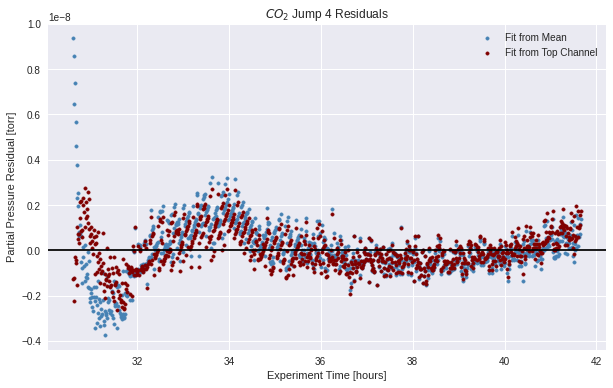

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_out[0]/3600, CO2_jump4_out[1] - CO2_jump4_out[2], marker='.', color='steelblue', label='Fit from Mean')
ax.scatter(CO2_jump4_alt[0]/3600, CO2_jump4_alt[1] - CO2_jump4_alt[2], marker='.', color='maroon', label='Fit from Top Channel')
ax.set_ylabel('Partial Pressure Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.axhline(color='k')
ax.set_title('$CO_2$ Jump 4 Residuals')
ax.legend()

fig.savefig('images/co2_4_resid_2020_11_09.png', dpi=144)

plt.show()

In [40]:
#CO2_data['Pressure'].iloc[np.array(CO2_times.between(50000,110000))]

### Finding the Bounds of Each Jump

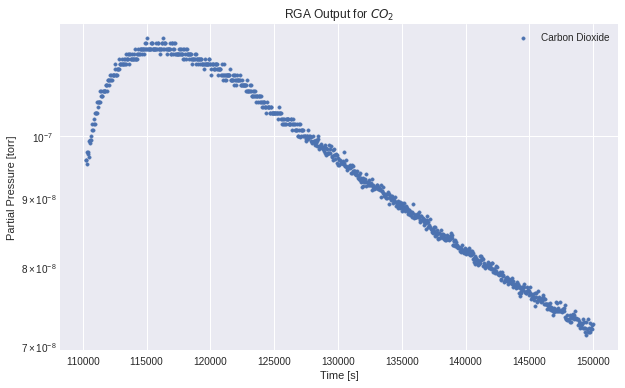

In [41]:
bnds = [110200, 150000]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_times.iloc[np.array(CO2_times.between(bnds[0],bnds[1]))],
           CO2_data['Pressure'].iloc[np.array(CO2_times.between(bnds[0],bnds[1]))], marker='.', label='Carbon Dioxide')
ax.set_title('RGA Output for $CO_2$')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Partial Pressure [torr]')
ax.legend()
ax.set_yscale('log')

plt.show()

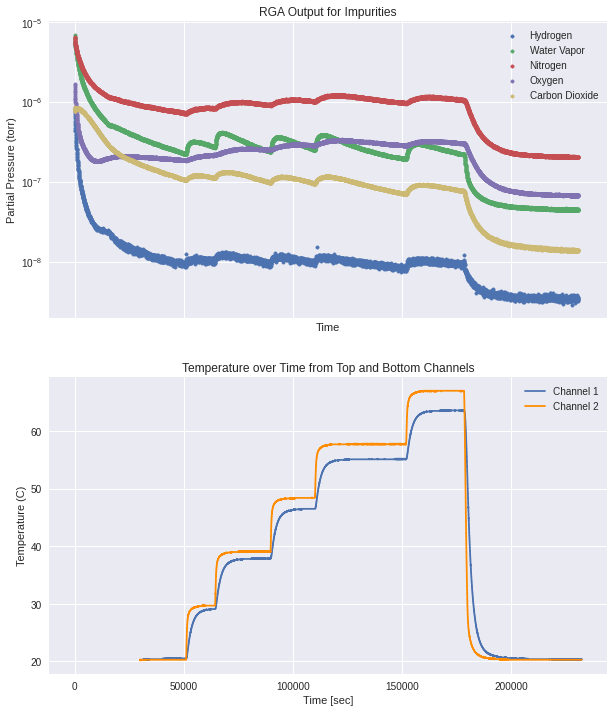

In [42]:
fig, ax = plt.subplots(figsize=(10,12),  nrows = 2, sharex=True)
ax[0].scatter(H2_times, H2_data['Pressure'], marker='.', label='Hydrogen')
ax[0].scatter(H2O_times, H2O_data['Pressure'], marker='.', label='Water Vapor')
ax[0].scatter(N2_times, N2_data['Pressure'], marker='.', label='Nitrogen')
ax[0].scatter(O2_times, O2_data['Pressure'], marker='.', label='Oxygen')
ax[0].scatter(CO2_times, CO2_data['Pressure'], marker='.', label='Carbon Dioxide')
ax[0].set_title('RGA Output for Impurities')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Partial Pressure (torr)')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
ax[1].set_title('Temperature over Time from Top and Bottom Channels')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Temperature (C)')
ax[1].legend()

fig.savefig('plot_out_2020_11_09.png', dpi=300)
plt.show()

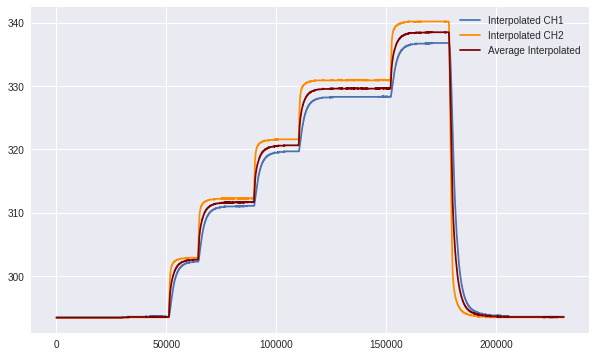

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch1_lerp'], label='Interpolated CH1')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['temp_est'], label='Average Interpolated', color='maroon')
ax.legend()

plt.show()

In [44]:
#IO.RemoveZipDir()